In [1]:
%matplotlib widget

import sys
import os.path as op
from glob import glob

import numpy as np
from scipy.io import loadmat
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import mne
from mne.io import read_epochs_eeglab
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm

In [13]:
def fit_ssd(data, info):
    """Alpha-band Spatio-Spectral Decomposition (SSD) from raw data"""
    #freqs_sig = 9, 14  # alpha
    #freqs_noise = 8, 15  # alpha
    freqs_sig = 15, 29  # beta
    freqs_noise = 14, 30  # beta
    # freqs_sig = 35, 45  # gamma
    # freqs_noise = 30, 50  # gamma

    ssd = SSD(info=info,
              reg='oas',
              sort_by_spectral_ratio=True,
              filt_params_signal=dict(l_freq=freqs_sig[0],
                                      h_freq=freqs_sig[1],
                                      l_trans_bandwidth=1,
                                      h_trans_bandwidth=1),
              filt_params_noise=dict(l_freq=freqs_noise[0],
                                     h_freq=freqs_noise[1],
                                     l_trans_bandwidth=1,
                                     h_trans_bandwidth=1))
    data_filtered = ssd.fit_transform(X=data)
    return data_filtered, ssd


def read_data(subj_id, series_num, data_dir, pick_channels=None):
    # read in both pre- and post-TMS sessions belonging to a single subject
    series_num = str(series_num)
    subj_id = subj_id.zfill(4)
    fname_t1 = op.join(data_dir, 'series_' + series_num, 'T1/preprocessed',
                       subj_id + '_Pre_Session1_Series' + series_num + '_Preprocessed.set')
    fname_t2 = op.join(data_dir, 'series_' + series_num, 'T2/preprocessed',
                       subj_id + '_Post_Session1_Series' + series_num + '_Preprocessed.set')

    # read in data
    epochs_pre_post = list()
    for fname in [fname_t1, fname_t2]:
        epochs = read_epochs_eeglab(fname)
        if pick_channels is not None:
            epochs = epochs.pick_channels(pick_channels)
        epochs_data = epochs.get_data().squeeze()
        #epochs_data -= np.mean(epochs_data, axis=(1, 2), keepdims=True)
        #epochs_data /= np.std(epochs_data, axis=(1, 2), keepdims=True)
        epochs_pre_post.append(epochs_data)
    epochs_info = epochs.info  # save for fit_ssd()
    epoch_times = epochs.times  # save save for spec_event_coherence_shift()
    
    return epochs_pre_post, epochs_info, epoch_times


def spatio_spectral_shift(epochs_pre_post, epochs_info):
    ssd_weights = list()
    for sess_idx, epochs_data in enumerate(epochs_pre_post):
        filtered_data, ssd = fit_ssd(epochs_data, epochs_info)
        ssd_weights.append(ssd.patterns_[0])
    
    # compute stats across pre/post sessions
    ssd_std_diff = ssd_weights[1].std() - ssd_weights[0].std()
    ssd_weights_diff = ssd_weights[1] - ssd_weights[0]
    ssd_weights_diff_flip = ssd_weights[1] + ssd_weights[0]
    # note that some subjects have sessions where the spatial SSD pattern
    # remains consistent, but with opposite sign
    # given that an opposite sign of an SSD weight reflects a pi-radians phase
    # difference, here I explored the possibility that the sign assigned to a
    # given SSD vector is somewhat arbitrary by taking the SSD weight
    # difference with minimal magnitude
    ssd_norm = min(np.sqrt(np.mean(ssd_weights_diff ** 2)),
                   np.sqrt(np.mean(ssd_weights_diff_flip ** 2)))

    return ssd_std_diff, ssd_norm


def spec_event_coherence_shift(epochs_pre_post, times):
    # set path to SpectralEvents
    sys.path.append('/users/rthorpe/brainstorm-ws/spectral-events')
    import spectralevents as se
    
    event_band = [15, 29]  # beta band (Hz)
    thresh_FOM = 6.0  # factor-of-the-median threshold

    dt = times[1] - times[0]
    samp_freq = 1 / dt
    freqs = freqs = range(3, 40)
    
    time_bin = 0.025  # 25 ms
    binned_times = np.arange(0, times[-1] + time_bin, time_bin)
    n_bins = len(binned_times)
    
    pre_post_coherence = list()
    for epochs_data in epochs_pre_post:
        n_epochs = epochs_data.shape[0]
        n_chans = epochs_data.shape[1]
        event_raster = list()
        for chan_idx in range(n_chans):
            chan_events = np.zeros((n_epochs, n_bins))  # to store binary event flags
            chan_epochs_data = epochs_data[:, chan_idx, :].squeeze()
            
            # compute TFRs
            tfrs = se.tfr(chan_epochs_data, freqs, samp_freq)
            # find events
            spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                                         event_band=event_band, threshold_FOM=6.)
            
            n_events = [len(epoch_events) for epoch_events in spec_events]
            print(f'Found {sum(n_events)} beta events in current channel.')
            for epoch_idx, epoch_events in enumerate(spec_events):
                for event in epoch_events:
                    bin_idx = np.nonzero(binned_times > event['Peak Time'])[0][0]
                    chan_events[epoch_idx, bin_idx] = 1
            event_raster.append(chan_events)
            
            # sanity check: plot event_raster
            #plt.figure()
            #plt.pcolormesh(binned_times, np.arange(n_epochs), chan_events)
            
        event_intersection = event_raster[0] * event_raster[1]
        event_union = ((event_raster[0] + event_raster[1]) > 0).astype(int)
        sess_coherence = event_intersection.mean() / event_union.mean()
        
        print(f'Mean inter-hemisphere beta event coherence for current session: {sess_coherence}!!!')
        pre_post_coherence.append(sess_coherence)
    
    return pre_post_coherence[1] - pre_post_coherence[0]


def get_features(subj_id, series_num, data_dir):
    '''Main pipeline for computing all features for a given subject.'''
    epochs_pre_post, epochs_info, _ = read_data(subj_id, series_num, data_dir)
    ssd_std_diff, ssd_norm = spatio_spectral_shift(epochs_pre_post, epochs_info)
    
    epochs_pre_post_c3_c4, _, times = read_data(subj_id, series_num, data_dir, pick_channels=['C3', 'C4'])
    spec_event_coherence_diff = spec_event_coherence_shift(epochs_pre_post_c3_c4, times)
    
    return ssd_std_diff, ssd_norm, spec_event_coherence_diff


def plot_features_scatter(x, y, responder_labels, ax_labels):
    '''Plot features across subjects in a 2D scatter plot.'''
    g = sns.JointGrid()

    for class_idx, class_ in enumerate(set(responder_labels)):
        if class_ == 1:
            label = 'responders'
        else:
            label = 'non-responders'
        cluster_mask = responder_labels == class_
        x_data = np.array(x)[cluster_mask]
        y_data = np.array(y)[cluster_mask]

        # plot data points for a given class label (i.e., responder or non-responder)
        sns.scatterplot(x=x_data, y=y_data, alpha=.5, edgecolor=None,
                        color=f'C{class_idx + 1}', ax=g.ax_joint)

        # plot marginal distributions for a given class label
        sns.kdeplot(x=x_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
        g.ax_marg_x.axvline(np.mean(x_data), color=f'C{class_idx + 1}')
        sns.kdeplot(y=y_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_y)
        g.ax_marg_y.axhline(np.mean(y_data), color=f'C{class_idx + 1}')

    g.ax_joint.set_xlabel(ax_labels[0])
    g.ax_joint.set_ylabel(ax_labels[1])
    g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
    g.fig.tight_layout()

In [3]:
# set data directory
data_dir = '/gpfs/data/brainstorm-ws/data/'
data_type = 'TRAINING'

In [4]:
# read metadata from master list
fname_master = op.join(data_dir, data_type, data_type + '_Master List_All Series.csv')
master_keys = np.loadtxt(fname_master,  delimiter=',', max_rows=1, dtype=str)
master_keys[0] = 'TMSID'  # fix first key string
master_values = np.loadtxt(fname_master, delimiter=',', skiprows=1, dtype=str)
master_info = {key: master_values[:, master_keys == key].squeeze() for key in master_keys}

# get subject IDs for subject series with both pre-/post-TMS EEG recordings
subj_select = master_info['HasT1T2'] == '1'
subj_ids = master_info['TMSID'][subj_select]
n_series_recordings = sum(subj_select)

In [5]:
# read metadata from demographics and clinical outcomes
fname_outcomes = op.join(data_dir, data_type, data_type + '_Demographics and Clinical Outcomes_All Series.csv')
outcomes_keys = np.loadtxt(fname_outcomes,  delimiter=',', max_rows=1, dtype=str)
outcomes_keys[0] = 'TMSID'  # fix first key string
outcomes_values = np.loadtxt(fname_outcomes, delimiter=',', skiprows=1, dtype=str)
outcome_info = {key: outcomes_values[:, outcomes_keys == key].squeeze() for key in outcomes_keys}

# get demographic and outcome data for each subject series
ages = outcome_info['AgeTMSstart'][subj_select].astype(int)
sexes = outcome_info['Sex'][subj_select].astype(int)
depression_histories = outcome_info['SevHxDep'][subj_select].astype(int)
responders = outcome_info['LastRespIDSSR'][subj_select].astype(int)

# get series number for each subject series
series_nums = outcome_info['Series'][subj_select].astype(int)

In [6]:
# test analysis pipeline
#data_type_dir = op.join(data_dir, data_type)
#ssd_std_diff, ssd_norm, spec_event_coherence_diff = get_features(subj_ids[0], series_nums[0], data_type_dir)

In [7]:
# run spatio-spectral decomposition analysis
# use embarrassingly parallel loop across subject series to speed things up
n_jobs = 12
data_type_dir = op.join(data_dir, data_type)
out = Parallel(n_jobs=n_jobs)(delayed(get_features)(subj_ids[idx], series_nums[idx], data_type_dir)
                              for idx in range(n_series_recordings))
ssd_std_diffs, ssd_norms, spec_event_coherence_diffs = zip(*out)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T1/preprocessed/0091_Pre_Session1_Series4_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0116_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
80 matching events found
Not setting metadata
79 matching events found
Not setting metadata
75 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0167_Pre_Session1_Series2_Preprocessed.set...
0 projection items activated
No b

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0250_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0255_Post_Session1_Ser

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 H

Done.
Done.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Effective window size : 1.000 (s)
    Using tolerance 2.3e-12 (2.2e-16 eps * 64 dim * 1.6e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---

Done.
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandw

Reducing data rank from 64 -> 64
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.9e-12 (2.2e-16 eps * 64 dim * 3.5e+02  max singular value)
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Computin

    Using tolerance 3.1e-12 (2.2e-16 eps * 64 dim * 2.2e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0256_Pre_Session1_Series1_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0256_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
71 matching events found
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Done.
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Ex

    Using tolerance 1.8e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Found 213 beta events in current channel.
Found 280 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04329004329004329!!!
Found 339 beta events in current channel.
Found 341 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04272151898734177!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0274_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
99 matching events found
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pa

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0293_Post_Session1_Series2_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
93 matching events found
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Desig

Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 7.7e-12 (2.2e-16 eps * 64 dim * 5.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Found 234 beta events in current channel.
Found 234 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03409090909090909!!!
Found 245 beta events in current channel.
Found 231 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03803131991051454!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0296_Pre_Session1_Series2_Preprocessed.set...
Computing rank from data with rank=None
Not setting metadata
86 matching events found
Effective window size : 1.000 (s)
    Using tolerance 6.2e-12 (2.2e-16 eps * 64 dim * 4.4e+02  max singular value)
No baseline correction applied
0 projection items activated
Ready.
Reduci

Done.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Found 366 beta events in current channel.
Found 408 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.015193370165745856!!!
Found 422 beta events in current channel.
Found 417 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.01903553299492386!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0296_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0296_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15

Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
Computing rank from data with rank=None
    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective window size : 1.000 (s)
Found 365 beta events in current channel.
Found 405 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0485021398002853!!!
Found 289 beta events in current channel.
Found 265 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04296875!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0302_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Computing rank from data

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)
Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
    Using tolerance 6.3e-12 (2.2e-16 eps * 64 dim * 4.5e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------

Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
    Using tolerance 2.6e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window s

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0296_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0296_Post_Session1_Series2_Preprocessed.set...
Set

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4608 out of 4608 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

Done.
Effective window size : 1.000 (s)
    Using tolerance 1.3e-11 (2.2e-16 eps * 64 dim * 9.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 7.2e-12 (2.2e-16 eps * 64 dim * 5.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Reducing data 

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5120 out of 5120 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Found 404 beta events in current channel.
Found 476 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03128911138923655!!!
Found 263 beta events in current channel.
Found 294 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.02443609022556391!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0330_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0302_Pre_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
Not setting metadata
99 matching events found
Not setting metadata
74 matching events found
Done.
Estimating covariance using OAS
No baseline correction applied
0 projection items activ

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4800 out of 4800 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 1.2e-11 (2.2e-16 eps * 64 dim * 8.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
    Using tolerance 2.1e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5120 out of 5120 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

Computing rank from data with rank=None
Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0296_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
93 matching events found
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Done.
Done.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- L

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

Computing rank from data with rank=None
    Using tolerance 6.4e-12 (2.2e-16 eps * 64 dim * 4.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5696 out of 5696 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 7.6e-13 (2.2e-16 eps * 64 dim * 54  max singular value)
Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband 

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4352 out of 4352 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Using tolerance 6.6e-12 (2.2e-16 eps * 64 dim * 4.6e+02  max singular value)
    Using tolerance 1.2e-11 (2.2e-16 eps * 64 dim * 8.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Done.
Comput

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
Done.
    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filt

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6464 out of 6464 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

Done.
Computing rank from data with rank=None
Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
    Using tolerance 2.3e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 1.6e-12 (2.2e-16 eps * 64 dim * 1.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Found 434 beta events in current channel.
Found 403 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03234152652005175!!!
Found 73 beta events in current channel.
Found 108 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.022988505747126436!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0356_Pre_Session1_Series3_Prepr

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Found 481 beta events in current channel.
Found 504 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03854625550660793!!!
Found 409 beta events in current channel.
Found 368 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03194444444444444!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0362_Pre_Session1_Series1_Preprocessed.set..

/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6592 out of 6592 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remai

    Using tolerance 9.8e-12 (2.2e-16 eps * 64 dim * 6.9e+02  max singular value)
    Using tolerance 9.2e-12 (2.2e-16 eps * 64 dim * 6.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using

    Using tolerance 6.2e-12 (2.2e-16 eps * 64 dim * 4.4e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 1.5e-11 (2.2e-16 eps * 64 dim * 1.1e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
    Using tolerance 7.2e-12 (2.2e-16 eps * 64 dim * 5.1e+02  max singular value)
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
    Using tolerance 1.6e-12 (2.2e-16 eps * 64 dim * 1.1e+02  max singular value)
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0353_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 8.8e-12 (2.2e-16 eps * 64 dim * 6.2e+02  max singular value)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covari

No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
    Using tolerance 3.2e-12 (2.2e-16 eps * 64 dim * 2.2e+02  max singular value)
Found 515 beta events in current channel.
Found 445 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.017937219730941704!!!
Found 496 beta events in current channel.
Found 465 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.030821917808219176!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0370_Pre_Session1_Series1_Preprocessed.set...
    Using tolerance 8.6e-12 (2.2e-16 eps * 64 dim * 6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
    Estimated rank (eeg): 64
    EEG: rank 64 comp

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Done.
Estimating covariance using OAS
Effective window size : 1.000 (s)
Done.
Effective window size : 1.000 (s)
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 5.6e-12 (2.2e-16 eps * 64 dim * 4e+02  max singular value)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Estimate

    Using tolerance 4.7e-12 (2.2e-16 eps * 64 dim * 3.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Found 412 beta events in current channel.
Found 371 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.01646090534979424!!!
Found 320 beta events in current channel.
Found 293 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04107142857142857!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0378_Pre_Session1_Series1_Preprocessed.set...
Estimating covariance using OAS
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Done.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0378_Post_Session1_Series1_Pre

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4992 out of 4992 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

Found 304 beta events in current channel.
Found 343 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.030050083472454095!!!
Found 275 beta events in current channel.
Found 299 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.01286764705882353!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0378_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz

    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Found 351 beta events in current channel.
Found 380 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.02467343976777939!!!
Found 349 beta events in current channel.
Found 347 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03384615384615385!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0380_Pre_Session1_Series1_Preprocessed.set...
    Using tolerance 3.1e-12 (2.2e-16 eps * 64 dim * 2.2e+02  max singular value)
Not setting metadata
81 matching events found
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: ra

Reducing data rank from 64 -> 64
    Using tolerance 6.1e-12 (2.2e-16 eps * 64 dim * 4.3e+02  max singular value)
Found 383 beta events in current channel.
Found 433 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.012987012987012988!!!
Found 542 beta events in current channel.
Found 592 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.033428844317096466!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0389_Pre_Session1_Series1_Preprocessed.set...
Estimating covariance using OAS
Not setting metadata
87 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0389_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
90 mat

Estimating covariance using OAS
Done.
    Using tolerance 1e-11 (2.2e-16 eps * 64 dim * 7e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 1.4e-12 (2.2e-16 eps * 64 dim * 95  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0370_Pre_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4864 out of 4864 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0370_Post_Session1_Series1_Preprocessed.set...
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
    Using tolerance 4.8e-12 (2.2e-16 eps * 64 dim * 3.4e+02  max singular value)
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequenc

Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0378_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Found 385 beta events in current channel.
Found 351 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.030882352941176472!!!
Found 380 beta events in current channel.
Found 295 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04105090311986863!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0401_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0406_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found
Done.
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 8.1e-12 (2.2e-16 eps * 64 dim * 5.7e+02  max singular value)
Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6144 out of 6144 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 H

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0413_Post_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 

Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 3.5e-12 (2.2e-16 eps * 64 dim * 2.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 9.6e-12 (2.2e-16 eps * 64 dim * 6.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 2.2e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4800 out of 4800 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

Found 476 beta events in current channel.
Found 549 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.029136316337148804!!!
Found 386 beta events in current channel.
Found 423 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03038309114927345!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0419_Pre_Session1_Series1_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
101 matching events found
Done.
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 1.6e-11 (2.2e-16 eps * 64 dim * 1.1e+03  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0419_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
    Estimated rank (eeg): 64
    EEG: ra

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4736 out of 4736 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

Effective window size : 1.000 (s)
    Using tolerance 7.7e-12 (2.2e-16 eps * 64 dim * 5.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
    Using tolerance 3.5e-12 (2.2e-16 eps * 64 dim * 2.5e+02  max singular value)
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Fi

Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 64 dim * 90  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
    Using tolerance 6.3e-12 (2.2e-16 eps * 64 dim * 4.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective win

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6016 out of 6016 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

Done.
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4992 out of 4992 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0406_Pre_Session1_Series1_Preprocessed.set...
Estimating covariance using OAS
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0406_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.
Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5824 out of 5824 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0421_Post_Session1_Series2_Preprocessed.set...
    Using tolerance 1.1e-11 (2.2e-16 eps * 64 dim * 7.5e+02  max singular value)
Estimating covariance using OAS
Not setting metadata
106 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upp

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0416_Post_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
67 matching events found
Reducing data rank from 64 -> 64
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0423_Post_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 1

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5376 out of 5376 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

Computing rank from data with rank=None
Done.
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 1.6e-12 (2.2e-16 eps * 64 dim * 1.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
    Using tolerance 2.3e-12 (2.2e-16 eps * 64 dim * 1.6e+02  max singular value)
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass fi

Effective window size : 1.000 (s)
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-12 (2.2e-16 eps * 64 dim * 1.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)
Found 398 beta events in current channel.
Found 447 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.021518987341772152!!!
Found 326 beta events in current channel.
Found 394 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03731343283582089!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0436_Pre_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-pha

Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 1.3e-12 (2.2e-16 eps * 64 dim * 95  max singular value)
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition 

Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 1.4e-12 (2.2e-16 eps * 64 dim * 98  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 3.7e-12 (2.2e-16 eps * 64 dim * 2.6e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0422_Pre_Session1_Series1_Preprocessed.set...
Estimating covariance using OAS
Not setting metadata
86 matching events found
    Using tolerance 3.8e-12 (2.2e-16 eps * 64 dim * 2.7e+02  max singular value)
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 8768 out of 8768 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_199902/3540824480.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=

Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-12 (2.2e-16 eps * 64 dim * 5.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Found 393 beta events in current channel.
Found 362 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.01694915254237288!!!
Found 298 beta even

Reducing data rank from 64 -> 64
Done.
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5568 out of 5568 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5568 out of 5568 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  

Effective window size : 1.000 (s)
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
    Using tolerance 3.2e-12 (2.2e-16 eps * 64 dim * 2.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: ran

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0436_Pre_Session1_Series1_Preprocessed.set...
    Using tolerance 4.8e-12 (2.2e-16 eps * 64 dim * 3.4e+02  max singular value)
Not setting metadata
81 matching events found
    Estimated rank (eeg): 64
    EEG:

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Done.
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Found 448 beta events in current channel.
Found 448 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.028985507246376812!!!
Found 456 beta events in current channel.
Found 418 beta events in current channel.
Mean inter-hemisphere beta event coh

Done.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
Found 282 beta events in current channel.
Found 283 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.022770398481973434!!!
Found 280 beta events in current channel.
Found 319 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.01615798922800718!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/9001_Pre_Session1_Series2_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2

Done.
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge:

    Using tolerance 2.2e-12 (2.2e-16 eps * 64 dim * 1.6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_6/T1/preprocessed/9001_Pre_Session1_Series6_Preprocessed.set...
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_6/T2/preprocessed/9001_Post_Session1_Series6_Preprocessed.set...
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Ready.


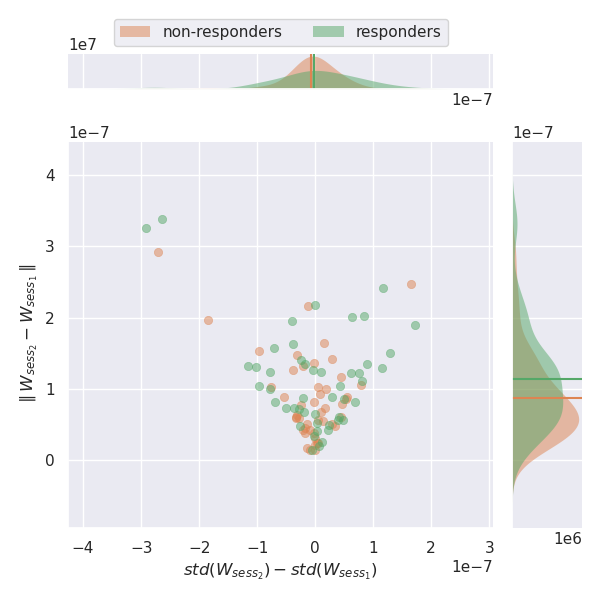

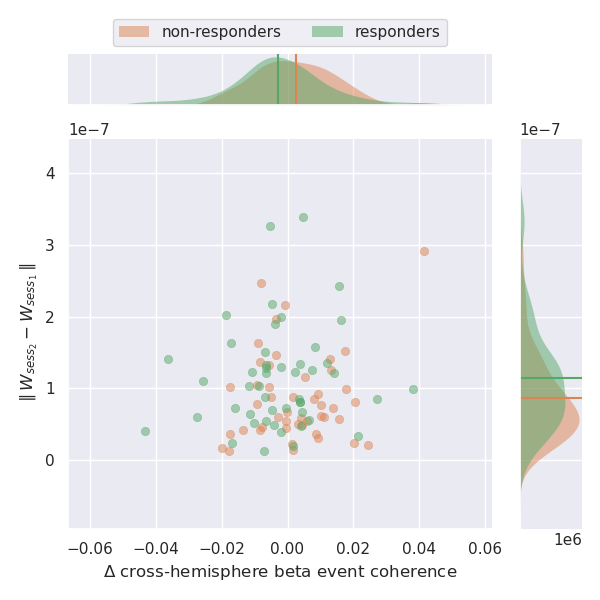

In [14]:
# plot 1st and 2nd features
ax_labels = [r'$std(W_{sess_2})-std(W_{sess_1})$', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
plot_features_scatter(x=ssd_std_diffs, y=ssd_norms, responder_labels=responders, ax_labels=ax_labels)

# plot 1st and 3rd features
ax_labels = [r'$\Delta$ cross-hemisphere beta event coherence', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
plot_features_scatter(x=spec_event_coherence_diffs, y=ssd_norms, responder_labels=responders, ax_labels=ax_labels)

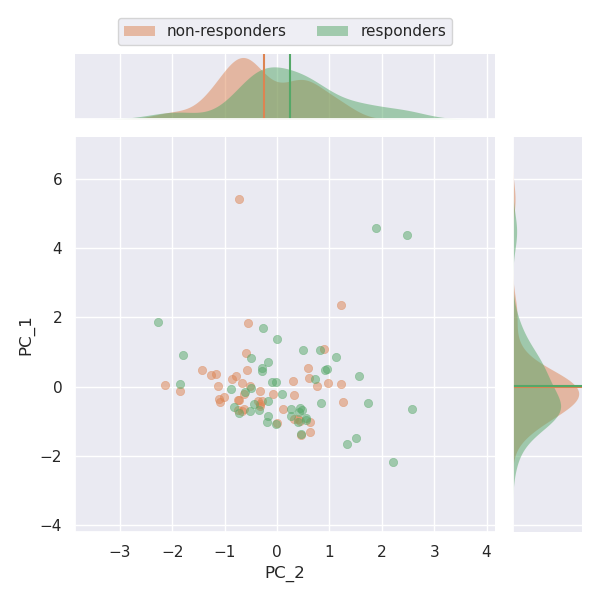

In [15]:
# PCA: see if the two data classes appear to be linearly separable
# answer: nope
X = np.c_[ssd_norms, ssd_std_diffs, spec_event_coherence_diffs]
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
pcs = pca.components_[:2, :]
X_pc = X @ pcs.T

ax_labels = ['PC_2', 'PC_1']
plot_features_scatter(x=X_pc[:, 1], y=X_pc[:, 0], responder_labels=responders, ax_labels=ax_labels)